In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os, random
from typing import Dict, Tuple
from scipy.stats import pearsonr,spearmanr, chi2_contingency, ttest_ind, f_oneway, mannwhitneyu, shapiro

# Static Functions
def get_patient(file_name: str) -> pd.DataFrame:
    patient_data = pd.read_csv(file_name, delimiter='|')
    return patient_data


class statistical_experiments:
    def __init__(self, data_path, pre_attack_hours, features) -> None:
        self.data_path = data_path
        self.pre_attack_hours = pre_attack_hours
        self.attack_dictionary = dict()
        self.no_attack_dictionary = dict()
        self.all_patients = dict()
        self.attack_df = pd.DataFrame()
        self.no_attack_df = pd.DataFrame()
        self.attack_feature_dictionary = dict()
        self.no_attack_feature_dictionary = dict()
        self.results_dictionary_averages = dict()
        self.results_dictionary_gradients = dict()
        self.test_features = features
        self.get_patients_dicts()
        self.get_feature(self.test_features)

    def trim_patient(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, bool]:
        """
        Trims the patient df to the first appearence of the spesis label (if there is one).
        Args:
            df: The patient dataframe
        Returns:
            A dataframe that goes up to and including the start of the attack.
            A Boolean value for wherther the patient suffered an attack.
        """
        had_attack = 1 if sum(df['SepsisLabel']) > 0 else 0
        if had_attack:
            attack_start = int(df['SepsisLabel'].idxmax())
            trimmed = df.iloc[:attack_start+1] # Take up-tuntil the attack.
            df_final = pd.DataFrame()
            if len(trimmed) >= self.pre_attack_hours:
                df_final = trimmed[-self.pre_attack_hours:].reset_index() # Take only the last 7 hours before the attack. 
            return df_final, True
        df_final = df[:self.pre_attack_hours]
        return df_final.reset_index(), False
    
    def get_patients_dicts(self):
        """
        Args:
            folder_name: The path of the folder that holds the psv files of the patients
        Returns:
            A dictionary of patient_number: pd.Dataframe
            Note: This function will eliminate any sick patients will less than 6 hours before the attack.
        """
        print("Getting Data...")
        for filename in tqdm(os.listdir(self.data_path)):
            patient_id = os.path.splitext(filename)[0].split('_')[1]
            patient_df = get_patient(os.path.join(self.data_path, filename))
            trimmed_patient_df, had_attack = self.trim_patient(patient_df)
            if len(trimmed_patient_df)==0:
                continue
            if had_attack:
                self.attack_dictionary[int(patient_id)] = trimmed_patient_df
            else:
                self.no_attack_dictionary[int(patient_id)] = trimmed_patient_df

    def get_feature(self, feature_list: list):
        """
        Creates a verticle dataframe of one feature for all patients and adds it to the feature_dictionary
        """
        df_out = pd.DataFrame()
        cols = []
        # Attack Data
        for feature in feature_list:
            for data in self.attack_dictionary.values():
                col = data[feature].copy()
                cols.append(col)
            df_out = pd.concat(cols, axis=1)
            self.attack_feature_dictionary[feature] = df_out
            cols = []

            # No Attack Data
            for data in self.no_attack_dictionary.values():
                col = data[feature].copy()
                cols.append(col)
            df_out = pd.concat(cols, axis=1)
            self.no_attack_feature_dictionary[feature] = df_out
            cols = []
        
    def add_features(self, new_feature_list: list):
        self.get_feature(new_feature_list)

    def calc_grad(self, row):
        feature = list(row)
        y_1 = feature[0] if pd.notna(feature[0]) else feature[1]
        y_2 = feature[-2] if pd.notna(feature[-2]) else feature[-3]
        delta_x =self.pre_attack_hours-1
        return (y_2-y_1)/delta_x

In [6]:
my_stats = statistical_experiments("/home/student/hw1/data/train", 10,  ['HR', 'Temp',  'MAP', 'Resp','DBP',
       'BaseExcess', 'HCO3', 'BUN', 'Bilirubin_direct', 'Magnesium','Potassium',
       'Bilirubin_total', 'Hgb', 'Fibrinogen', 'Age', 'Gender', 'HospAdmTime', 'ICULOS'])

Getting Data...


100%|██████████| 20000/20000 [00:48<00:00, 409.81it/s]


# Starting the Experimentation

In [7]:
def t_test(x1, x2):
    stat, p = ttest_ind(x1, x2)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Not enough evidence to reject the null hypothesis!')
    else:
        print('We reject the null hypothesis!')
    return p

In [8]:
def anova(x1, x2):
    stat, p = f_oneway(x1, x2)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')
    return p

In [9]:
def mann_whitney_u(x1,x2):
    stat, p = mannwhitneyu(x1, x2)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Not enough evidence to reject the null hypothesis!')
    else:
        print('We reject the null hypothesis!')
    return p

In [10]:
def shapiro_wilk_normality(x1,x2) -> int:
    stat1, p1 = shapiro(x1)
    stat2, p2 = shapiro(x2)
    print('Group: Attack, stat=%.3f, p=%.3f' % (stat1, p1))
    if p1 > 0.05:
        print('Probably Gaussian')
    else:
        print('Probably not Gaussian')
    print('Group: No Attack, stat=%.3f, p=%.3f' % (stat2, p2))
    if p2 > 0.05:
        print('Probably Gaussian')
    else:
        print('Probably not Gaussian')
    return int((p1> 0.05) & (p2>0.05))

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns

def run_test(feature, test, test_name, plot):
    a_feature = my_stats.attack_feature_dictionary[feature].fillna(method='ffill')
    na_feature = my_stats.no_attack_feature_dictionary[feature].fillna(method='ffill')

    a_feature = a_feature.T
    na_feature = na_feature.T

    a_feature['ave'] = np.mean(a_feature, axis=1)
    na_feature['ave'] = np.mean(na_feature, axis=1)

    a_feature['grad'] = a_feature.apply(lambda row: my_stats.calc_grad(row.values[:-1]), axis=1)
    na_feature['grad'] = na_feature.apply(lambda row: my_stats.calc_grad(row.values[:-1]), axis=1)

    # patient averages
    a_feature_ave = a_feature['ave'].dropna().values
    na_feature_ave = na_feature['ave'].dropna().values

    #patient gradeints
    a_grad = a_feature['grad'].dropna().values
    na_grad = na_feature['grad'].dropna().values

    if test_name not in my_stats.results_dictionary_averages:
        my_stats.results_dictionary_averages[test_name] = []
        my_stats.results_dictionary_gradients[test_name] = []

    # Test for Average
    print(f"__________________{test_name}____________________")
    print(" ")
    print(f".........{test_name} for average {feature}.........")
    p_value = test(a_feature_ave, na_feature_ave)
    my_stats.results_dictionary_averages[test_name].append(p_value)
    
    # Test for gradient
    print(f".........{test_name} for {feature} average gradient.........")
    p_value = test(a_grad, na_grad)
    my_stats.results_dictionary_gradients[test_name].append(p_value)
   

    if plot:
        sns.histplot(a_feature_ave, kde=True, label="Attack")
        sns.histplot(na_feature_ave, kde=True, label="No Attack")
        plt.title(f"Average {feature}")
        plt.legend()
        filename = "/home/student/hw1/data_visualisation/Distributions/Average_"+feature+".png"
        plt.savefig(filename)
        plt.clf()

        sns.histplot(a_grad, kde=True, label="Attack")
        sns.histplot(na_grad, kde=True, label="No Attack")
        plt.title(f"{feature} gradient")
        plt.legend()
        filename = "/home/student/hw1/data_visualisation/Distributions/Average_gradient_"+feature+".png"
        plt.savefig(filename)
        plt.clf()


    


## Heart Rate

### t-test for Average HR and HR-average_gradient

In [12]:
# run_test('HR', t_test, "t-test", True)


## Testing All Features:

In [22]:
for feature in ['HR', 'Temp',  'MAP', 'Resp','DBP',
       'BaseExcess', 'HCO3', 'BUN', 'Bilirubin_direct', 'Magnesium','Potassium',
       'Bilirubin_total', 'Hgb', 'Fibrinogen', 'HospAdmTime', 'ICULOS']:  # Still need 'Age', 'Gender
    print(f"============={feature}============")
    run_test(feature, shapiro_wilk_normality, "Shapior-Wilk Normality", False)
    run_test(feature,t_test,"t-test", False)
    run_test(feature, anova, "Analysis of Varience Test (ANOVA)", False)
    run_test(feature, mann_whitney_u, "Mann-Whitney U Test", False)

=============HR============
__________________Mann-Whitney U Test____________________
 
.........Mann-Whitney U Test for average HR.........
stat=10874714.000, p=0.000
We reject the null hypothesis!
.........Mann-Whitney U Test for HR average gradient.........
stat=9178494.500, p=0.000
We reject the null hypothesis!
=============Temp============
__________________Mann-Whitney U Test____________________
 
.........Mann-Whitney U Test for average Temp.........
stat=11454785.000, p=0.000
We reject the null hypothesis!
.........Mann-Whitney U Test for Temp average gradient.........
stat=1440798.000, p=0.000
We reject the null hypothesis!
=============MAP============
__________________Mann-Whitney U Test____________________
 
.........Mann-Whitney U Test for average MAP.........
stat=8579181.000, p=0.010
We reject the null hypothesis!
.........Mann-Whitney U Test for MAP average gradient.........
stat=9547297.000, p=0.000
We reject the null hypothesis!
=============Resp============
________

In [14]:
df_pvalues_aves = pd.DataFrame(my_stats.results_dictionary_averages, index=['HR', 'Temp',  'MAP', 'Resp','DBP',
       'BaseExcess', 'HCO3', 'BUN', 'Bilirubin_direct', 'Magnesium','Potassium',
       'Bilirubin_total', 'Hgb', 'Fibrinogen', 'HospAdmTime', 'ICULOS'])

df_pvalues_grads = pd.DataFrame(my_stats.results_dictionary_gradients, index=['HR', 'Temp',  'MAP', 'Resp','DBP',
       'BaseExcess', 'HCO3', 'BUN', 'Bilirubin_direct', 'Magnesium','Potassium',
       'Bilirubin_total', 'Hgb', 'Fibrinogen', 'HospAdmTime', 'ICULOS'])

In [15]:
df_pvalues_grads

,Shapior-Wilk Normality,t-test,Analysis of Varience Test (ANOVA),Mann-Whitney U Test
HR,0,1.130957e-05,1.130957e-05,4.758619e-05
Temp,0,3.643465e-28,3.643465e-28,4.252682e-30
MAP,0,4.913492e-14,4.913492e-14,8.520521e-16
Resp,0,6.845755e-01,6.845755e-01,8.926734e-01
DBP,0,1.348525e-11,1.348525e-11,2.929364e-13
BaseExcess,0,2.564355e-01,2.564355e-01,3.040596e-02
HCO3,0,3.579145e-01,3.579145e-01,4.882651e-01
BUN,0,8.058350e-01,8.058350e-01,5.903759e-01
Bilirubin_direct,0,9.243619e-01,9.243619e-01,9.062906e-01
Magnesium,0,7.261497e-02,7.261497e-02,8.279408e-02


In [16]:
df_pvalues_aves

,Shapior-Wilk Normality,t-test,Analysis of Varience Test (ANOVA),Mann-Whitney U Test
HR,0,1.375102e-26,1.375102e-26,1.492182e-24
Temp,0,8.400022e-75,8.400022e-75,1.671088e-64
MAP,0,5.256817e-04,5.256817e-04,9.547473e-03
Resp,0,3.225835e-63,3.225835e-63,1.555454e-50
DBP,0,1.446168e-06,1.446168e-06,1.083265e-05
BaseExcess,0,1.154240e-13,1.154240e-13,1.951332e-15
HCO3,0,5.845979e-04,5.845979e-04,2.729584e-03
BUN,0,9.554320e-12,9.554320e-12,2.551895e-14
Bilirubin_direct,0,5.609246e-01,5.609246e-01,1.367539e-02
Magnesium,0,1.157881e-12,1.157881e-12,1.045017e-16


In [17]:
def plot_pvalue_map(df, measure):
    # Define the color palette
    colors = ["#00FF00", "#FFFFFF"]

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(10, 8))

   
    # Draw the heatmap with green for values below 0.05 and white for values above 0.05, and box outlines
    sns.heatmap(df, cmap=sns.color_palette(colors), mask=None, annot=True, fmt=".3f", 
                vmax=1, vmin=0, center=0.05, square=True, linewidths=1, cbar=False, ax=ax,
                linecolor='gray', cbar_kws={"orientation": "horizontal"})

    # Set the x-axis label to be empty
    ax.set_xlabel('')

    # Move the y-axis labels to the left side
    ax.tick_params(axis='y', labelleft=True, labelright=False)

    # Add the column names to the top of the heatmap
    ax.set_xticklabels(df.columns, rotation=45)

    # Set the title of the plot
    plt.title(f"Heatmap of p-values for {measure}")

    # Display the plot
    plt.show()








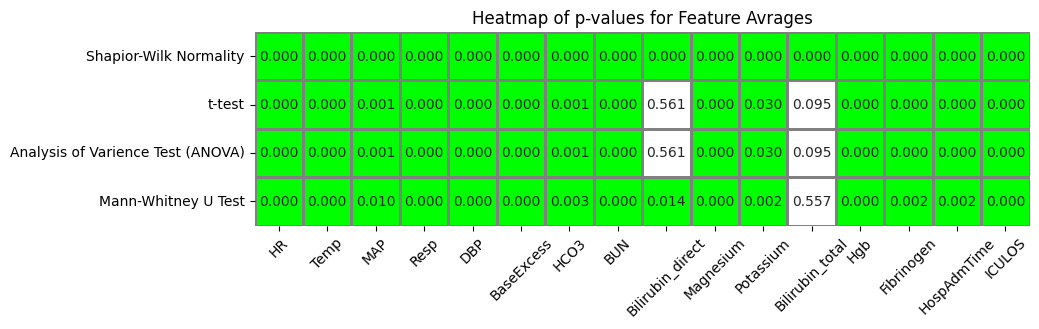

In [18]:
plot_pvalue_map(df_pvalues_aves.T, "Feature Avrages")

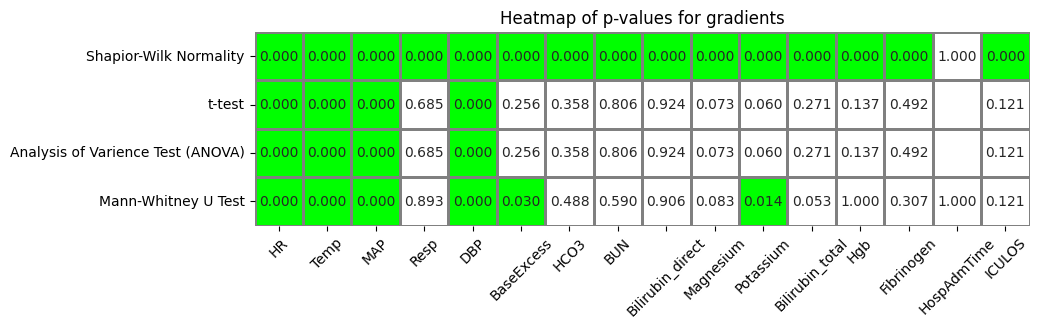

In [19]:
plot_pvalue_map(df_pvalues_grads.T, "gradients")

In [20]:
sick = my_stats.attack_dictionary
no_sick = my_stats.no_attack_dictionary

dict_for_pd = {'Age':[], "Gender":[], "Unit1":[], "Unit2":[], "Sepsis":[]}
final_demographic_df = pd.DataFrame()
patient_ids = []
for patient, data in sick.items():
    patient_ids.append(patient)
    dict_for_pd['Sepsis'].append(1)
    dict_for_pd['Age'].append(data.loc[0, 'Age'])
    dict_for_pd['Gender'].append(data.loc[0, 'Gender'])
    dict_for_pd['Unit1'].append(data.loc[0, 'Unit1'])
    dict_for_pd['Unit2'].append(data.loc[0, 'Unit2'])
for patient, data in no_sick.items():
    patient_ids.append(patient)
    dict_for_pd['Sepsis'].append(0)
    dict_for_pd['Age'].append(data.loc[0, 'Age'])
    dict_for_pd['Gender'].append(data.loc[0, 'Gender'])
    dict_for_pd['Unit1'].append(data.loc[0, 'Unit1'])
    dict_for_pd['Unit2'].append(data.loc[0, 'Unit2'])


In [21]:
df_for_eyal = pd.DataFrame(data=dict_for_pd, index=patient_ids)
t = df_for_eyal.sort_index()
t

,Age,Gender,Unit1,Unit2,Sepsis
0,75.91,0,0.0,1.0,0
1,65.79,1,NaN,NaN,1
2,52.88,1,1.0,0.0,0
3,49.52,1,NaN,NaN,0
4,73.00,1,1.0,0.0,0
...,...,...,...,...,...
19995,59.71,1,0.0,1.0,0
19996,65.83,1,NaN,NaN,0
19997,79.42,0,1.0,0.0,0
19998,38.75,1,0.0,1.0,0
